Formato dati: int16
Lunghezza record: 4000.0
File root: \Users\alexb\OneDrive\Documenti\Lab_locale\iqcorrection\iqcorrection_src\Data\Spectra\run34\
['MixCh1_5785937577.txt', 'MixCh2_5785937577.txt', 'run34_spectra0.000']
(file_names) First file: MixCh1_5785937577.txt
(file_names) Last file: run34_spectra0.000


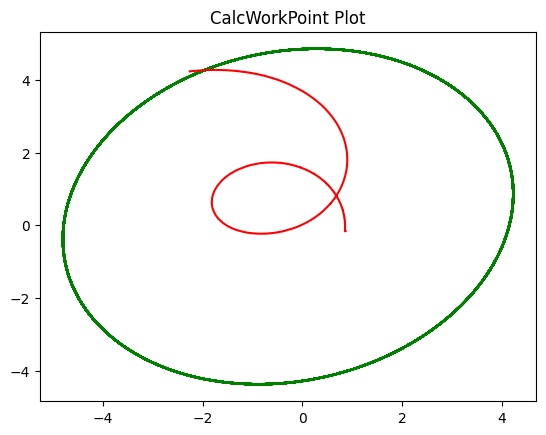

Frequency difference for the 0-th channel: 277423.0
Signal frequency for the 1-th channel probe: 5786215000.0
Calibration file for the 1-th channel mixer: MixCh1_5785937577.txt


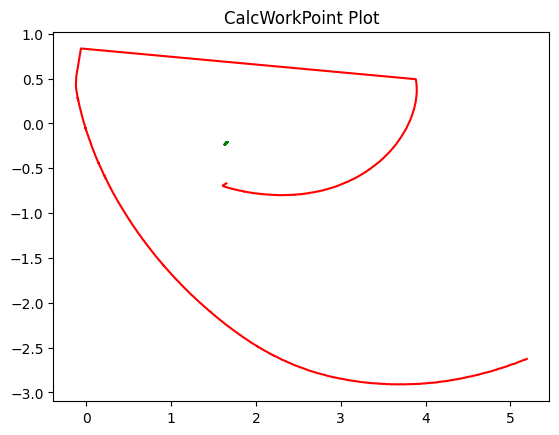

Frequency difference for the 1-th channel: 68852423.0
Signal frequency for the 2-th channel probe: 5854790000.0
Calibration file for the 2-th channel mixer: MixCh1_5785937577.txt


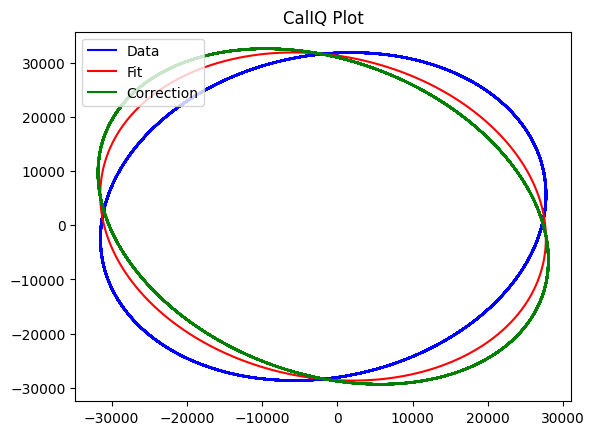

Correct Frequency range


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [1]:
import numpy as np
import os
import sys
from matplotlib import pyplot as plt

#All the scripts we are going to use are defined in different .py files, in order to make them easier to manage. 
from loadconfiguration import LoadConfiguration
from logconversion import LogConversion
from getspectrafile import GetSpectraFile 
from calcworkpoint import CalcWorkPoint
from findmixcal import FindMixCal
from caliq import Cal_IQ
from shift2pos import Shift2Pos
from backgroundcalibration import BackgroundCalibration
from correctiq import CorrectIQ
from correctiqbackground import CorrectIQBackground
from readdata import ReadData

#All our globally defined variables are stored in "globalvariables.py". This ensures the code does not encounter cyclic definition of variables 
#and thus ensures stability.
import globvar

#def ConvertIQ2Af4(run_num, meas_num, spectra_path, iqpath, save_path, iqheader, mode, nch,  datatype):

#Default settings block. Useful in order to debug the code, these should be the argument for the ConvertIQ2Af4 function.
spectra_path = '\\Users\\alexb\\OneDrive\\Documenti\\Lab_locale\\iqcorrection\\iqcorrection_src\\Data\\Spectra'
run_num = 34
datatype = 'MixCh'
meas_num = 1
save_path = '\\Users\\alexb\\OneDrive\\Documenti\\Lab_locale\\iqcorrection\\iqcorrection_src\\Save'
iqpath = '\\Users\\alexb\\OneDrive\\Documenti\\Lab_locale\\iqcorrection\\iqcorrection_src\\IQ' + '\\run' + str(run_num) + '\\'
iqheader = ['IQ0Ch1', 'IQ0Ch2']
nch = 2
mode = 0
ifplot = 1

#The row below should be the original command, but its argument does not correspond to the log file we want to pick.
#config = loadconfiguration.LoadConfiguration(spectra_path + "\\run" + str(run_num) + '\\' + datatype + str(meas_num) + ".log")
config = LoadConfiguration(spectra_path + "\\run" + str(run_num) + '\\' + datatype + str(meas_num) + '_5785937577' + '.log')

#We modify recordlength and adcconv globally...
globvar.recordlength = float(config[2][1])
globvar.adcconv = float(config[0][1])
samprate = float(config[1][1])
attenuations = [float(config[14][1]) + float(config[15][1])]
dataformat = globvar.dataformat

#...then we store them in a local variable.
recordlength = globvar.recordlength
adcconv = globvar.adcconv

#Show how data have been arranged
print('Formato dati: ' + str(globvar.dataformat))
print('Lunghezza record: ' + str(globvar.recordlength))

#------------Search for all INPUT----------
#We modify checkpath and logpath globally...
globvar.checkpath = save_path + '\\check_meas' + datatype + str(meas_num)
globvar.logpath = save_path + '\\run' + str(run_num) + '\\' + datatype + str(meas_num) +'.log'

#...then we store them in a local variable. Their content should not be modified later, and the other script
#we will call can retain the value we assigned in the earlier rows by importing the value, now updated as to lines 48 and 49.
logpath = globvar.logpath
checkpath = globvar.checkpath

#Create directories in which store correction results and logs
os.mkdir(save_path)
os.mkdir(save_path + '\\run' + str(run_num))
log = open(logpath, 'a')
log.close()
os.mkdir(checkpath)

globvar.nchan = nch
nchan = globvar.nchan

#For each channel IQ data we declare a proper string
iqfileheader_ch = []
for ii in range(nch):
    iqfileheader_ch.append(iqpath + str(iqheader[ii]))

#Create the list of spectra files. Note we use the symbols "\\" instead of "\" for paths, otherwise it wouldn't work.
data_base_filename = spectra_path + '\\' + 'run' + str(run_num) + '\\'
print('File root: ' + data_base_filename)
file_names = GetSpectraFile(data_base_filename)
print(file_names)

if not file_names:
    print('Error: no spectra file found')

#Let's see the first and the final file retrieved
print('(file_names) First file: ' + str(file_names[0]))
print('(file_names) Last file: ' + str(file_names[-1]))

#We now want to compute the WorkPoint frequency
posch = np.zeros(nch)
fmeas = np.zeros(nch)
fmeas2 = np.zeros(nch)
cal_mix_file = ([[]]*nch)

for ii in range (nch):
    [posch[ii], fmeas[ii]] = CalcWorkPoint(data_base_filename + file_names[0], recordlength, 2*nch, 2*ii, 2*ii+1, iqfileheader_ch[ii], mode, ifplot)
    fmeas2[ii] = float(config[10 + ii][1])
    print('Frequency difference for the ' + str(ii) + '-th channel: ' + str(fmeas[ii]-fmeas2[ii]))

    #Find mixer calibration file closest to the frequency working point
    cal_mix_file[ii] = FindMixCal(fmeas[ii], spectra_path + '\\run' + str(run_num), ii + 1)
    print('Signal frequency for the ' + str(ii + 1) + '-th channel probe: ' + str(fmeas[ii]))
    print('Calibration file for the ' + str(ii + 1) + '-th channel mixer: ' + str(cal_mix_file[ii]))

    #Now ALL input are defined. It's possible to create the log file. The function "logconversion" recalls the 
    #matlab script "logconversion2.m" +  probably an updated version of the original "logconversion.m".
    #Refer to "logconversion2.m" for comparision
LogConversion(fmeas, run_num, meas_num, spectra_path, iqpath, iqheader, cal_mix_file, mode, nch, recordlength)

mixercalfile_ch = []
mixer = []
background = np.zeros(nch)
s21xch = np.zeros(nch)
s21ych = np.zeros(nch)
f = np.zeros(nch)
qvalues = np.zeros(nch)

fmax = np.zeros(nch)
fmin = np.zeros(nch)
amax = np.zeros(nch)
amin = np.zeros(nch)
a = ([[]]*nch)
bufamp = ([[]]*nch)
buffreq = ([[]]*nch)
bufpulse = ([[]]*nch)

for ii in range(nch):
    #Create the string path for mixercalibration. The "ii-th" entry of the
    #object "mixercalfile_ch" is the path to the calibration file for the
    #"ii-th" channel

    mixercalfile_ch.append(spectra_path + '\\run' + str(run_num) + '\\' + cal_mix_file[ii])

    #---------Begin the IQ loop calibration--------#

    #First we characterize the loop, i.e. we find the parameters that best describe our non - ideal IQ mixer
    mixer.append(Cal_IQ(mixercalfile_ch[ii], 2*nch, 2*ii, 2*ii+1, 1, cal_mix_file[ii], nch))
    
    #Fit the mixer calibration data file and find the coefficients used for the correction

    #Fit the background and return the fixed IQ loop

    [background[ii], s21xch[ii], s21ych[ii], f[ii], qvalues[ii]] = BackgroundCalibration(iqfileheader_ch[ii], mixer[ii], fmeas[ii], ifplot)

    #Read and convert the pulse data files
    fmax[ii] = -1000000
    fmin[ii] = 1000000
    amax[ii] = -1000000
    amin[ii] = 1000000
    a[ii] = []
    bufamp[ii] = []
    buffreq[ii] = []
    bufpulse[ii] = []

original = sys.stdout
log = open(logpath, 'a')
sys.stdout = log
print('\nWritten Files\n')
sys.stdout = original
log.close()

idata = np.zeros(nch)
qdata = np.zeros(nch)
a = np.zeros(nch)
pulse_data = np.zeros(nch)
mapped_pulse_data = np.zeros(nch)
amplitude_signal = np.zeros(nch)
frequency_signal = np.zeros(nch)
t = np.zeros(nch)

for jj in range(len(file_names)):
    #generate the read file name and open
    fid = open(spectra_path + '/' + file_names[jj])

    #generate the write file name and open
    writefilename = save_path + str(file_names[jj][0:-5]) + '_proc' + str(file_names[jj][-4:-1])

    #Write file on screen and on log file
    fidwrite = open(writefilename, 'w')
    log = open(logpath, 'a')
    print(str(file_names[ii] + str(writefilename)))
    sys.stdout = original
    print(str(file_names[ii] + str(writefilename)))
    log.close()

    npoints = recordlength
    hh = 0

    while True:
        line = fid.readline()

        data = np.fromfile(fid, [2*nch, npoints], dataformat, 0, 'b')

        if str(data):
            #correct for the mixer - first remove the DC offsets.  We could either use
            #the offset IQ scan or use the offsets found from the IQ calibration data
            #5/2^15 is the ADC to volts scaling

            for ii in range(nch):
                idata[ii] = data[2*ii][:]
                #Idata{ii} = 5*Idata{ii}(:)/2^15;
                qdata[ii] = data[2*ii + 1][:]
                #Qdata{ii} = 5*Qdata{ii}(:)/2^15;

                if dataformat == 'int16':
                    idata[ii] = np.multiply(adcconv, idata[ii][:]/(2**15))
                    qdata[ii] = np.multiply(adcconv, qdata[ii][:]/(2**15))
                
                #apply a correction if it's needed (i.e. mode ~= 0)
                if mode != 0:
                    [idata[ii], qdata[ii], t[ii]] = Shift2Pos(idata[ii], qdata[ii], iqfileheader_ch[ii], ii, hh, ii, posch[ii], ifplot)
                    a[ii] = np.append(a[ii], np.sqrt(t[ii][0]**2 + t[ii][1]**2))

                idata[ii] = idata[ii] - background[ii].i0
                qdata[ii] = qdata[ii] - background[ii].q0

                #now correct for the mixer gains and phase errors
                [idata[ii], qdata[ii]] = CorrectIQ(idata[ii], qdata[ii], mixer[ii])
            
                #then apply the background correction
                pulse_data[ii] = CorrectIQBackground(fmeas[ii]*np.ones(np.size(idata[ii])), complex(idata[ii], qdata[ii]), background[ii])
                
                
                #next apply the rotations as applied to the IQ loop
                pulse_data[ii] = 1 - np.multiply(np.multiply(np.cos(background[ii].LoopRotation), np.exp( -1j*background[ii].LoopRotation)), (1 - np.multiply(pulse_data[ii], np.exp(-1j * background[ii].OverallRotation))))
            
                #now we can convert the timestream data into frequency and dissipation signals
                #through the transformation S_21_mapped = 1 / 1 - S21
                mapped_pulse_data[ii]= np.divide(1, (1 - pulse_data[ii]))
                amplitude_signal[ii] = np.real(mapped_pulse_data[ii])
                frequency_signal[ii] = np.imag(mapped_pulse_data[ii])

                

9158.95568144527 8364.687039732933 [-2577.52896226] [-8711.68931277] 0.7732180444420135


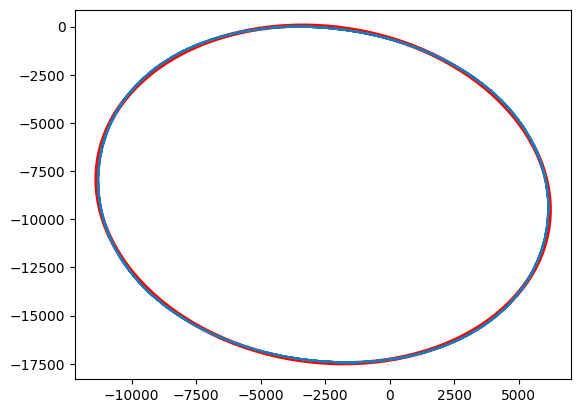

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from readdata import ReadData
from matplotlib.patches import Ellipse
from ellipsefit import EllipseFit

npoints = 4000
filename = '\\Users\\alexb\\OneDrive\\Documenti\\Lab_locale\\iqcorrection\\iqcorrection_src\\Data\\Spectra\\run24\\MixCh1_3980300000.txt'
[idata, qdata] = ReadData(filename, 4, 0, 1, 45, npoints)
plt.plot(idata, qdata)
[semimajor, semiminor, x0, y0, al] = EllipseFit(idata, qdata)
print(semimajor, semiminor, x0, y0, al)
e = Ellipse((x0, y0), 2*semimajor, 2*semiminor, angle = -np.rad2deg(al))
a = plt.subplot(111)
e.set_fill('')
e.set_color('r')
e.set_linewidth(3)
a.add_artist(e)
plt.show()

In [ ]:
print(data)

[[ -8784. -14416.  32764.  11724.]
 [ -8824. -14380.  32764.  11720.]
 [ -8860. -14328.  32764.  11728.]
 ...
 [ -3668. -17204.  32764.  11708.]
 [ -3744. -17196.  32764.  11704.]
 [ -3792. -17180.  32764.  11704.]]


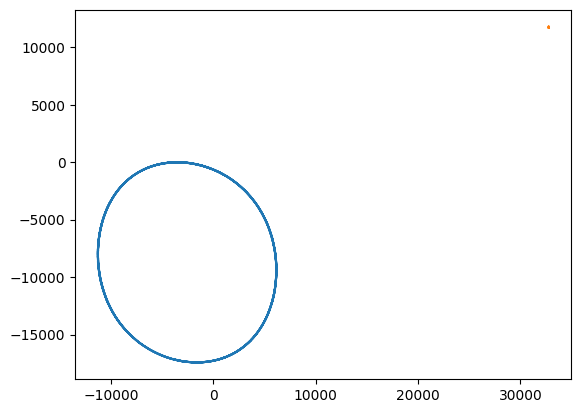

In [ ]:
plt.plot(data[:, 0], data[:, 1])
plt.plot(data[:, 2], data[:, 3])

In [ ]:
from readdata import ReadData
from loadiq import LoadIQ
from matplotlib import pyplot as plt
from matplotlib.patches import Ellipse
from ellipsefit import EllipseFit

npoints = 4000
iqfileheader = '\\Users\\alexb\\OneDrive\\Documenti\\Lab_locale\\iqcorrection\\iqcorrection_src\\IQ\\run24\\IQ1Ch1'
[f, idata, qdata] = LoadIQ(iqfileheader + '_')
[semimajor_axis, semiminor_axis, x0, y0, phi] = EllipseFit(idata, qdata)
Ellipse((x0, y0), 2*semimajor_axis, 2*semiminor_axis)

- LoadIQ(): OK: frequency file loaded: \Users\alexb\OneDrive\Documenti\Lab_locale\iqcorrection\iqcorrection_src\IQ\run24\IQ1Ch1_0.txt
- LoadIQ(): OK: frequency file loaded: \Users\alexb\OneDrive\Documenti\Lab_locale\iqcorrection\iqcorrection_src\IQ\run24\IQ1Ch1_1.txt
- LoadIQ(): OK: frequency file loaded: \Users\alexb\OneDrive\Documenti\Lab_locale\iqcorrection\iqcorrection_src\IQ\run24\IQ1Ch1_2.txt
